In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics

import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt

In [2]:
NCLASSES = 2
HEIGHT = 100
WIDTH = 100
NUM_CHANNELS = 3
BATCH_SIZE = 32

DATA_SET_COUNT = 27558
TEST_SET_COUNT = (DATA_SET_COUNT)*0.2
TRAIN_SET_COUNT = (DATA_SET_COUNT) * 0.6
VAL_SET_COUNT = (DATA_SET_COUNT) * 0.2
print(TEST_SET_COUNT,TRAIN_SET_COUNT, VAL_SET_COUNT)

5511.6 16534.8 5511.6


Vou começar por um modelo como tenho na cnn normal e treinar apenas essa parte: 
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    
Resultados:
[0.7546717054237521, 0.6459808]
Agora vou treinar a rede inteira:

Resultados:

[0.17221502138226363, 0.95917255]

Visto que a rede esta com os pesos do imagenet e esta não tem nada a ver com identificação de celulas fazer um treino parcial tem piores resultados. Como temos um numero suficiente de imagens é possivel treinar a rede toda com resultados bons

In [3]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,weights='imagenet', input_shape=(HEIGHT, WIDTH, NUM_CHANNELS))

base_model.trainable = True

print(base_model.summary())

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(2, activation='softmax')(x)

model_3 = models.Model(inputs=base_model.input, outputs=x)


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Auxiliary function for loading the dataset

In [4]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Load the dataset, replace the path with your own location of the dataset

In [5]:
data_dir = pathlib.Path('C:/Users/paulo/OneDrive/Ambiente de Trabalho/Escola/Apendizagem automatica 2/Trabalho/AA2/input/cell_images')
  
classNames = np.array(os.listdir(data_dir))
classNames

AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files("C:/Users/paulo/OneDrive/Ambiente de Trabalho/Escola/Apendizagem automatica 2/Trabalho/AA2/input/cell_images/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)


Split the dataset into training, validation and tedt sets

In [6]:
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
#dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset = dataset.repeat()

train_size = int(TRAIN_SET_COUNT)
val_size = int(VAL_SET_COUNT)
test_size= int(TEST_SET_COUNT)

train_dataset = dataset.take(train_size)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size = train_size)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.repeat();

test_dataset = dataset.skip(train_size)
test_dataset = test_dataset.take(test_size)
test_dataset = test_dataset.shuffle(buffer_size = train_size)
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE)

val_dataset = dataset.skip(train_size+test_size)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.repeat();


Load the test set

In [7]:
testset = test_dataset


Show a batch of images from the dataset

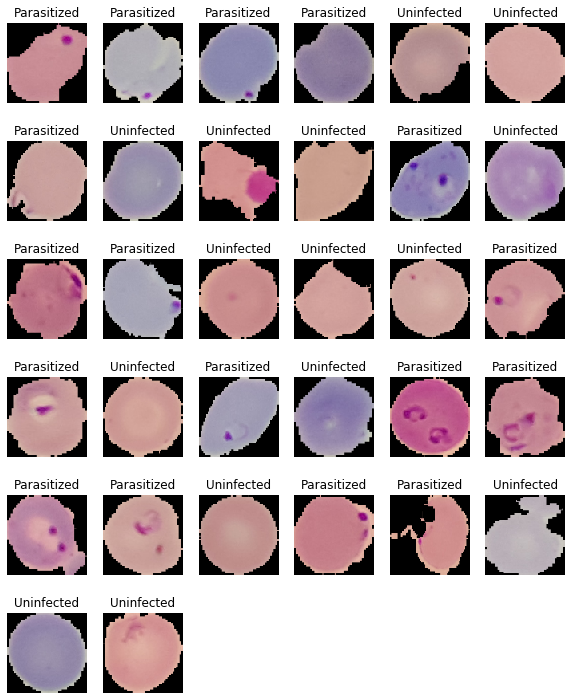

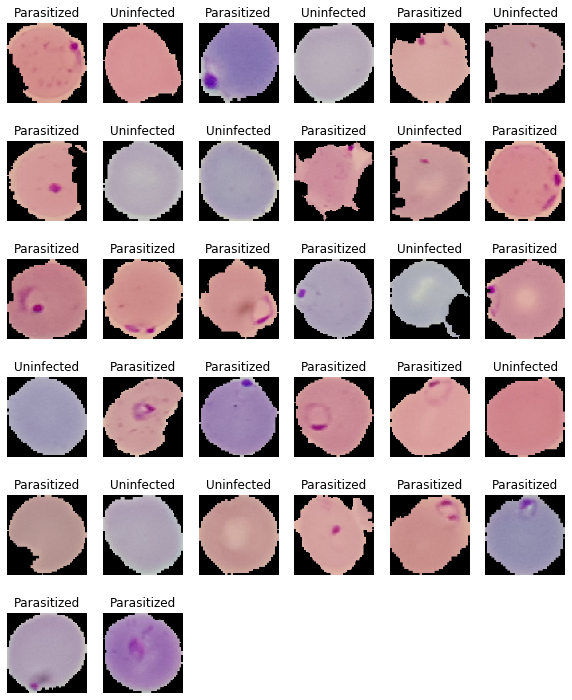

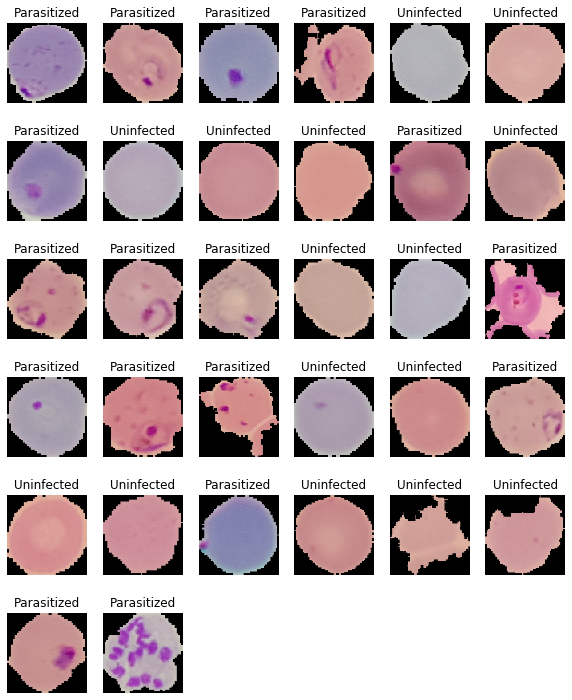

In [8]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(train_dataset))  
show_batch(image_batch, label_batch.numpy())

image_batch, label_batch = next(iter(val_dataset))  
show_batch(image_batch, label_batch.numpy())

image_batch, label_batch = next(iter(test_dataset))  
show_batch(image_batch, label_batch.numpy())

In [9]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])

history = model_3.fit(train_dataset, epochs=20, steps_per_epoch=train_size/BATCH_SIZE, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE)

model_3.evaluate(testset)

Train for 516.6875 steps, validate for 172.21875 steps
Epoch 1/20
517/516 [==============================] - 101s 195ms/step - loss: 0.3129 - categorical_accuracy: 0.8860 - val_loss: 0.3163 - val_categorical_accuracy: 0.8941
Epoch 2/20
517/516 [==============================] - 89s 172ms/step - loss: 0.2225 - categorical_accuracy: 0.9312 - val_loss: 0.3178 - val_categorical_accuracy: 0.8571
Epoch 3/20
517/516 [==============================] - 93s 179ms/step - loss: 0.1889 - categorical_accuracy: 0.9432 - val_loss: 0.2107 - val_categorical_accuracy: 0.9377
Epoch 4/20
517/516 [==============================] - 91s 177ms/step - loss: 0.2051 - categorical_accuracy: 0.9326 - val_loss: 53.9354 - val_categorical_accuracy: 0.8201
Epoch 5/20
517/516 [==============================] - 97s 188ms/step - loss: 0.1723 - categorical_accuracy: 0.9468 - val_loss: 0.1550 - val_categorical_accuracy: 0.9561
Epoch 6/20
517/516 [==============================] - 96s 186ms/step - loss: 0.1420 - categorical_

[0.17221502138226363, 0.95917255]

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


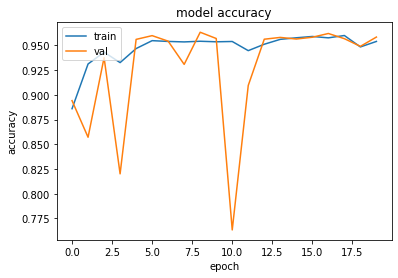

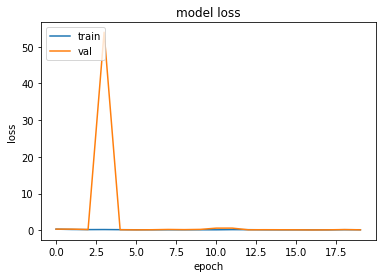

In [10]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()